In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
! curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
! git clone https://github.com/ryuntp/floodDetection.git

Cloning into 'floodDetection'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 185 (delta 12), reused 148 (delta 1), pack-reused 0
Receiving objects: 100% (185/185), 45.54 MiB | 26.74 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [0]:
path = Path('floodDetection')

In [0]:
path_labels = path/"labels"
path_images = path/'images'

In [7]:
filenames = get_image_files(path_images)
filenames[:10]

[PosixPath('floodDetection/images/Label_30.png'),
 PosixPath('floodDetection/images/Label_6.png'),
 PosixPath('floodDetection/images/Label_4.png'),
 PosixPath('floodDetection/images/Label_14.png'),
 PosixPath('floodDetection/images/Label_36.png'),
 PosixPath('floodDetection/images/Label_64.png'),
 PosixPath('floodDetection/images/Label_44.png'),
 PosixPath('floodDetection/images/Label_63.png'),
 PosixPath('floodDetection/images/Label_11.png'),
 PosixPath('floodDetection/images/Label_46.png')]

In [8]:
label_names = get_image_files(path_labels)
label_names[:10]

[PosixPath('floodDetection/labels/Label_41_P.png'),
 PosixPath('floodDetection/labels/Label_63_P.png'),
 PosixPath('floodDetection/labels/Label_19_P.png'),
 PosixPath('floodDetection/labels/Label_28_P.png'),
 PosixPath('floodDetection/labels/Label_55_P.png'),
 PosixPath('floodDetection/labels/Label_54_P.png'),
 PosixPath('floodDetection/labels/Label_56_P.png'),
 PosixPath('floodDetection/labels/Label_58_P.png'),
 PosixPath('floodDetection/labels/Label_43_P.png'),
 PosixPath('floodDetection/labels/Label_8_P.png')]

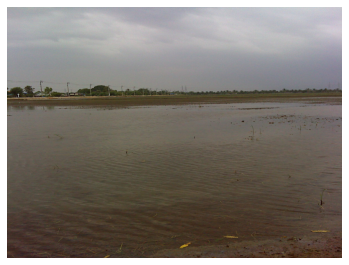

In [9]:
image_file = filenames[25]
image = open_image(image_file)
image.show(figsize=(6,6))

In [0]:
get_y_fn = lambda x: path_labels/f'{x.stem}_P{x.suffix}'

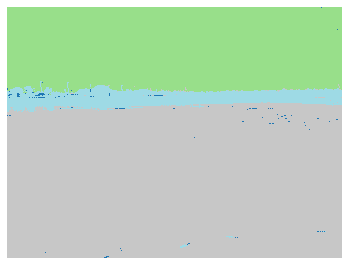

In [11]:
mask = open_mask(get_y_fn(image_file))
mask.show(figsize=(6,6), alpha=1)

In [12]:
source_size = np.array(mask.shape[1:])
source_size, mask.data

(array([720, 960]), tensor([[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3]]]))

In [13]:
codes = np.loadtxt(path/'code.txt', dtype=str)
len(codes), codes

(5, array(['Void', 'sky', 'rice', 'water', 'backg'], dtype='<U5'))

In [14]:
size = source_size//2
bs = 0

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 16000: bs=16    
elif free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11430MB of GPU RAM free


In [0]:
segmentitemlist = (SegmentationItemList.from_folder(path_images)
              .split_by_rand_pct(valid_pct=0.2)
              .label_from_func(get_y_fn, classes=codes))
# print(segmentitemlist)

In [0]:
databunch = (segmentitemlist.transform(get_transforms(), 
                                  size=size, tfm_y=True)
             .databunch(bs=bs)
             .normalize(imagenet_stats))

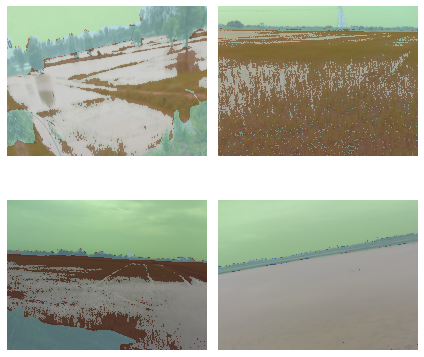

In [17]:
databunch.show_batch(2, figsize=(6, 6))

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
# metrics=accuracy

In [0]:
wd=1e-2

In [21]:
learner = unet_learner(databunch, models.resnet34, 
                       metrics=metrics, wd=wd, 
                       callback_fns=ShowGraph).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
lr=3e-3

epoch,train_loss,valid_loss,acc_camvid,time
0,1.465910,1.624093,0.178996,01:11
1,1.272602,1.081802,0.563431,00:17
2,1.098730,0.700016,0.771129,00:18
3,0.971632,0.651023,0.762065,00:18
4,0.880674,0.377762,0.852606,00:17
5,0.806815,0.470611,0.836944,00:17
6,0.784089,0.573613,0.823284,00:17
7,0.743691,0.340178,0.873820,00:17
8,0.698688,0.406723,0.846394,00:17
9,0.652655,0.311314,0.888330,00:17


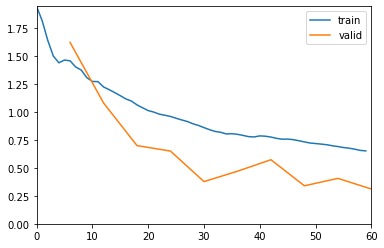

In [23]:
learner.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [0]:
learner.save('unet-resnet34-1')

In [0]:
learner.load('unet-resnet34-1');

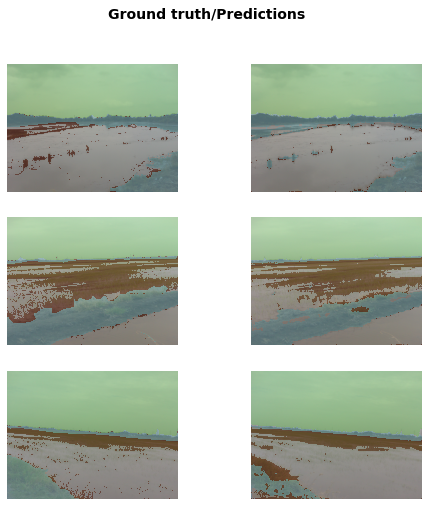

In [26]:
learner.show_results(rows=3, figsize=(8, 8))

In [0]:
learner.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.443821,0.292572,0.889870,00:19
1,0.417705,0.296218,0.882926,00:18
2,0.393867,0.285489,0.884404,00:18
3,0.382537,0.266135,0.896411,00:18
4,0.381302,0.265880,0.892351,00:18
5,0.389820,0.289902,0.896508,00:18
6,0.388773,0.257590,0.898811,00:18
7,0.381258,0.243897,0.907298,00:18
8,0.385794,0.304468,0.885732,00:18
9,0.385187,0.383939,0.875871,00:18


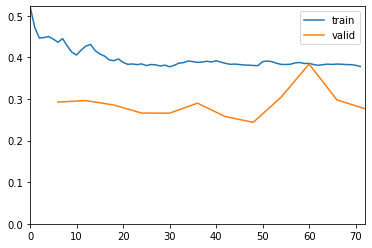

In [29]:
learner.fit_one_cycle(12, lrs, pct_start=0.8)

In [0]:
learner.save('unet-resnet34-2')

In [0]:
learner.load('unet-resnet34-2');

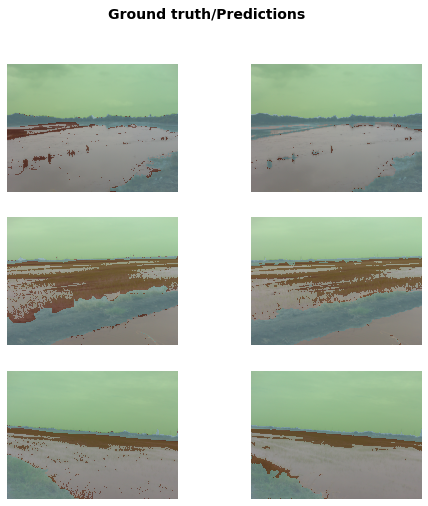

In [32]:
learner.show_results(rows=3, figsize=(8, 8))

In [0]:
learner.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.353426,0.275056,0.891473,00:18
1,0.333021,0.270090,0.894542,00:18
2,0.324753,0.266432,0.897440,00:18
3,0.319239,0.266139,0.899407,00:18
4,0.315071,0.257442,0.900515,00:18
5,0.312234,0.237601,0.907789,00:18
6,0.313419,0.250153,0.908750,00:18
7,0.314918,0.269396,0.896997,00:18
8,0.309037,0.233629,0.910705,00:18
9,0.304088,0.237332,0.910033,00:18


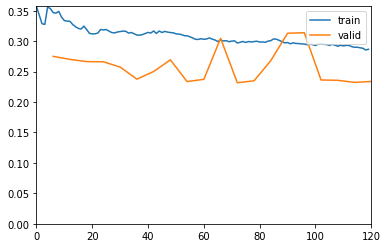

In [35]:
learner.fit_one_cycle(20, lrs, pct_start=0.8)

In [0]:
learner.save('unet-resnet34-3')

In [0]:
learner.load('unet-resnet34-3');

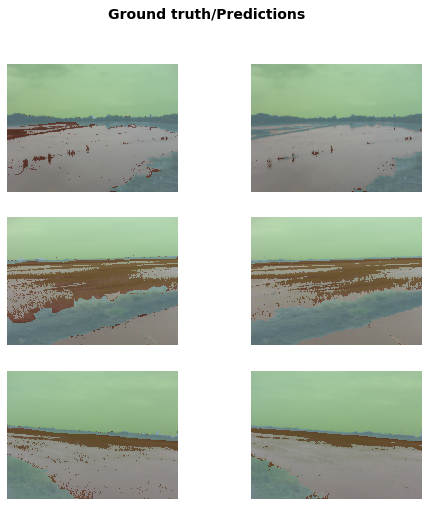

In [38]:
learner.show_results(rows=3, figsize=(8, 8))

** Test the model by inputing an unseen image**




In [0]:
path_test = path/"test"

In [40]:
test_img = get_image_files(path_test)
test_img[4]

PosixPath('floodDetection/test/1500004.jpg')

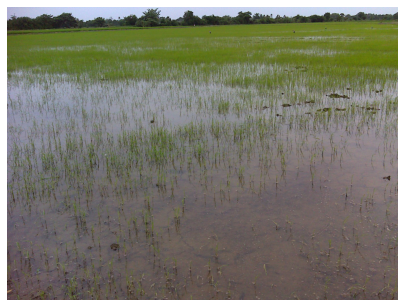

In [51]:
test_file = test_img[4]
timage = open_image(test_file)
timage.show(figsize=(7,7))

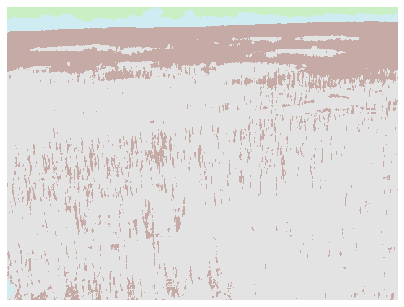

In [42]:
pred_class,pred_idx,outputs = learner.predict(timage);pred_class.show(figsize=(7,7))

In [43]:
databunch.classes

array(['Void', 'sky', 'rice', 'water', 'backg'], dtype='<U5')

In [44]:
resultArray= np.array(pred_idx)
unique, counts = np.unique(resultArray, return_counts=True)
print (unique,counts)

[1 2 3 4] [  5043  34576 126966   6215]


In [0]:
ricepixel = counts[1]
waterpixel = counts[2]

In [0]:
def calFlood(ricepixel,waterpixel):
  if waterpixel/ricepixel >=1:
    return "flooded"
  else:
    return "no flood"

In [50]:
calFlood(ricepixel,waterpixel)

'flooded'